# K-Means ile RFM Analizi ve Müşteri Segmentasyonu

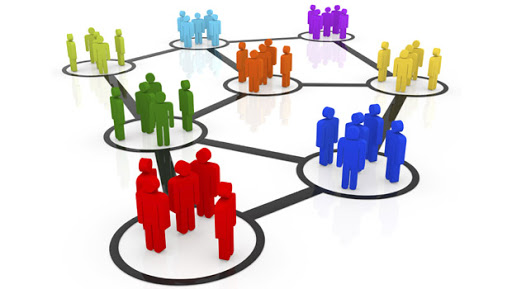

## İş Problemi

K-Means ile müşterilerin kümelenip segmentlenmesi beklenmektedir.

## Veri Seti Hikayesi

Online Retail II isimli veri seti İngiltere merkezli bir perakende şirketinin 01/12/2009 - 09/12/2011 tarihleri arasındaki online satış işlemlerini içeriyor. Şirketin ürün kataloğunda hediyelik eşyalar yer almaktadır ve çoğu müşterisinin toptancı olduğu bilgisi mevcuttur.

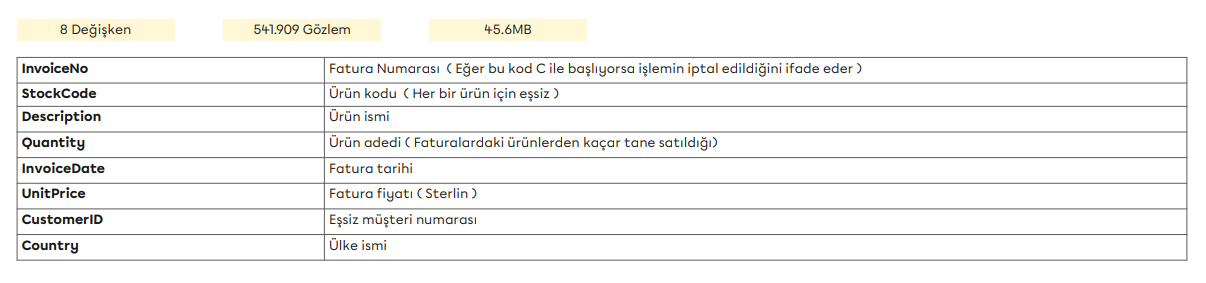

## Görev

K-Means'i kullanarak müşteri segmentasyonu yapınız. 

Müşterinin kaç gün önce alışveriş yaptığı, ne sıklıkla alışveriş yaptığı ve toplam harcadığı miktar gibi yeni değişkenler oluşturarak RFM analizi yapınız.

# Uygulama

In [129]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import datetime as dt

warnings.simplefilter(action='ignore', category=Warning)

from funcs.data_prep import *
from funcs.eda import *

## Veri Setinin Yüklenmesi

In [130]:
df = pd.read_excel("../datasets/online_retail_II.xlsx")

In [131]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Eksik Veriler

In [132]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

Customer ID ve description kolonlarında eksik veriler bulunuyor. Veri setinin bir kopyasını oluşturup bu eksik verileri siliyoruz. Ayrıca bazı faturaların başında C ifadesi yer alıyordu. Bu o siparişin iptal edildiğini ifade ediyor. Dolayısıyla iade edilen siparişler ile bir işimiz olmadığından dolayı iadeleri siliyoruz.

In [133]:
df_copy = df.dropna()

In [134]:
df_copy = df_copy[~df_copy["Invoice"].str.contains("C",na=False)]

In [135]:
df_copy.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [136]:
df_copy = df_copy.reset_index()

In [137]:
df_copy.drop("index", axis=1, inplace=True)

Bazı gözlem birimlerini veri setinden çıkardığımız için index numaralarını resetliyoruz. Resetlendikten sonra eski indexler "index" adı altında yeni bir kolon olarak veri setine dahil ediliyor, dolayısıyla onu da veri setinden drop ediyoruz.

In [138]:
df_copy.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [139]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407695 entries, 0 to 407694
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      407695 non-null  object        
 1   StockCode    407695 non-null  object        
 2   Description  407695 non-null  object        
 3   Quantity     407695 non-null  int64         
 4   InvoiceDate  407695 non-null  datetime64[ns]
 5   Price        407695 non-null  float64       
 6   Customer ID  407695 non-null  float64       
 7   Country      407695 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.9+ MB


Veri setinde aynı müşterinin birden fazla işlemi olduğundan dolayı toplam müşteri sayısını öğrenmek zor. Dolayısıyla "Country" ve "Customer ID" değişkenlerinden farklı bir df oluşturup ID ve ülke bilgisinin sadece bir kere yazılmasını sağlarsak ülkelere göre müşteri sayısını gözlemleyebiliriz.

Ayrıca olası bir durum olarak eğer bir işlem birden fazla kez veri seti içerisine eklenmişse aynı olan işlemleri veri setinden çıkarıyoruz ki yapacağımız analizimizi kötü yönde etkilemesin.

In [140]:
filtered_df=df_copy[['Country','Customer ID']].drop_duplicates()

In [141]:
filtered_df.head()

,Country,Customer ID
0,United Kingdom,13085.0
12,United Kingdom,13078.0
31,United Kingdom,15362.0
54,United Kingdom,18102.0
71,France,12682.0


Müşterilerin ID ve ülke bilgilerinin tutulduğu dataframe'i oluşturmuş olduk. Şimdi bir boxplot yardımıyla bunu görselleştirelim.

<AxesSubplot:>

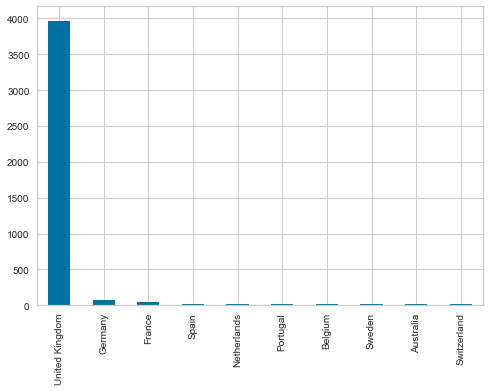

In [142]:
# Bazı ülkelerden dikkate değer sayıda müşteri bulunmadığından sadece ilk 10 ülkeyi getiriyoruz.
filtered_df["Country"].value_counts()[0:10].plot(kind='bar')

Grafik incelendiğinde, müşterilerin büyük bir çoğunluğu United Kingdom'dan alışveriş yapmışlar. Diğer ülkelerin müşteri sayıları görece çok az olduğundan dolayı sadece United Kingdom müşterileri üzerinden işlem yapmaya karar veriyoruz.

In [143]:
uk_data = df_copy[df_copy["Country"] == 'United Kingdom']

In [144]:
uk_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Artık İngiltere'deki müşterileri ayrı bir dataframe içerisinde tutuyoruz. Bu dataframe'in istatistiksel değerlerine bir göz atalım.

In [145]:
uk_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,370951.0,11.994444,67.394793,1.0,2.00,4.00,12.00,10000.0
Price,370951.0,3.145220,30.551482,0.0,1.25,1.95,3.75,10953.5
Customer ID,370951.0,15565.407693,1593.187209,12346.0,14215.00,15601.00,16940.00,18287.0


Price değişkeninde 0 olan değerler var. Bu değerleri hatalı olarak kabul edip veri setimizden çıkarıyoruz.

In [146]:
uk_data = uk_data[(uk_data['Price'] > 0)]

In [147]:
uk_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,370929.0,11.993058,67.388673,1.000,2.00,4.00,12.00,10000.0
Price,370929.0,3.145406,30.552378,0.001,1.25,1.95,3.75,10953.5
Customer ID,370929.0,15565.454823,1593.169081,12346.000,14215.00,15601.00,16941.00,18287.0


In [148]:
uk_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## RFM Analizi için Hazırlıklar

RFM analizi yapabilmemiz bize üç tane değişken gerekiyor. Bunlar; müşterilerin en son kaç gün önce alışveriş yaptığı, müşterinin toplam ne kadar ürün aldığı ve müşterinin firmaya toplam ne kadar para bıraktığının bilgilerini tutan değişkenler olacak. **Recency**, **Frequency**, **Monetary**.

Bunları hesaplamak için veri setinden gerekli olan değişkenleri bir arada bulundurmamız gerekiyor.

In [149]:
uk_data_copy = uk_data[['Customer ID','InvoiceDate','Invoice','Quantity','Price']]

In [150]:
uk_data_copy.head()

,Customer ID,InvoiceDate,Invoice,Quantity,Price
0,13085.0,2009-12-01 07:45:00,489434,12,6.95
1,13085.0,2009-12-01 07:45:00,489434,12,6.75
2,13085.0,2009-12-01 07:45:00,489434,12,6.75
3,13085.0,2009-12-01 07:45:00,489434,48,2.10
4,13085.0,2009-12-01 07:45:00,489434,24,1.25


Yukarıdaki *Price* değişkeni, müşterinin aldığı ürüne birim başı ne kadar fiyat ödediğinin bilgisini tutuyor. Dolayısıyla o ürün için toplam ne kadar harcadığını bulmak için bu değeri *Quantity*, yani adet değeri ile çarpıyoruz ve bunu *TotalPrice* değişkeni içerisinde tutuyoruz.

In [151]:
# ilgili ürün için toplam harcanan miktar
uk_data_copy['TotalPrice'] = uk_data_copy['Quantity'] * uk_data_copy['Price']

In [152]:
uk_data_copy.head()

,Customer ID,InvoiceDate,Invoice,Quantity,Price,TotalPrice
0,13085.0,2009-12-01 07:45:00,489434,12,6.95,83.4
1,13085.0,2009-12-01 07:45:00,489434,12,6.75,81.0
2,13085.0,2009-12-01 07:45:00,489434,12,6.75,81.0
3,13085.0,2009-12-01 07:45:00,489434,48,2.10,100.8
4,13085.0,2009-12-01 07:45:00,489434,24,1.25,30.0


Veri setinde yapılan son alışverişin tarihine bakarak güncel tarihi o günden 2 gün sonrası olarak belirleyeceğiz.

In [153]:
# yapılan ilk alışveriş ve yapılan son alışveriş tarihleri
uk_data_copy['InvoiceDate'].max()

Timestamp('2010-12-09 20:01:00')

Mağazada en son yapılan alışveriş 09-12-2010 tarihinde olduğunu görüyoruz. Dolayısıyla güncel tarihi bundan 2 gün sonrası, yani 11-12-2010 olarak belirliyoruz.

In [154]:
# son alışveriş yapılan tarihten 2 gün sonrasını şu an ki gün olarak varsayıyoruz
PRESENT = dt.datetime(2010,12,11)

uk_data_copy['InvoiceDate'] = pd.to_datetime(uk_data_copy['InvoiceDate'])

In [155]:
uk_data_copy.head()

,Customer ID,InvoiceDate,Invoice,Quantity,Price,TotalPrice
0,13085.0,2009-12-01 07:45:00,489434,12,6.95,83.4
1,13085.0,2009-12-01 07:45:00,489434,12,6.75,81.0
2,13085.0,2009-12-01 07:45:00,489434,12,6.75,81.0
3,13085.0,2009-12-01 07:45:00,489434,48,2.10,100.8
4,13085.0,2009-12-01 07:45:00,489434,24,1.25,30.0


In [156]:
uk_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370929 entries, 0 to 407694
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Customer ID  370929 non-null  float64       
 1   InvoiceDate  370929 non-null  datetime64[ns]
 2   Invoice      370929 non-null  object        
 3   Quantity     370929 non-null  int64         
 4   Price        370929 non-null  float64       
 5   TotalPrice   370929 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 19.8+ MB


# RFM Analizi

RFM analizi için; **recency**, **frequency** ve **monetary** değerlerini hesaplamamız gerekiyor. Bunları bir değişken olarak ayrı bir veri setinde tutacağız. Bunun için müşteri ID'lerini groupby'a alarak aşağıdaki işlemleri yapacağız;

- Recency için güncel tarihten müşterinin en son alışveriş yaptığı tarihi çıkararak kaç gün önce alışveriş yaptığını bulacağız.
- Frequency için müşterinin toplam yaptığı alışveriş sayısını bulacağız.
- Monetary için ise müşterinin tüm siparişlerinde harcadığı tutarın toplamını bulacağız.

In [157]:
rfm= uk_data_copy.groupby('Customer ID').agg({'InvoiceDate': lambda date: (PRESENT - date.max()).days,
                                        'Invoice': lambda num: len(num),
                                        'TotalPrice': lambda price: price.sum()})

In [158]:
rfm.head()

,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.0,165,33,372.86
12608.0,40,16,415.79
12745.0,122,22,723.85
12746.0,176,17,254.55
12747.0,5,154,5080.53


Artık her bir müşterinin toplam ne kadar harcadığı, en son ne zaman alışveriş yaptığı vs. bilgilerini gözlemleyebiliyoruz. Değişken isimlerini daha kolay işlem yapabilmemiz adına aşadığaki gibi değiştirelim.

In [159]:
# Change the name of columns
rfm.columns=['recency','frequency','monetary']

In [160]:
rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.0,165,33,372.86
12608.0,40,16,415.79
12745.0,122,22,723.85
12746.0,176,17,254.55
12747.0,5,154,5080.53


Recency değişkeni float tipinde değerler tutmakta. Bunları daha iyi skorlayabilmek adına int değerlerine çeviriyoruz.

In [161]:
rfm['monetary'] = rfm['monetary'].astype(int)

In [162]:
rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.0,165,33,372
12608.0,40,16,415
12745.0,122,22,723
12746.0,176,17,254
12747.0,5,154,5080


## Aykırı Değerler

Skorlama işlemine başlamadan önce veri setimizde aykırı değerlerin bulunup bulunmadığını kontrol edelim.

In [163]:
rfm.describe ([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
recency,3969.0,91.095742,97.072657,1.0,1.0,8.0,18.0,52.0,136.0,254.0,368.00,374.0
frequency,3969.0,93.456538,183.306124,1.0,1.0,8.0,18.0,43.0,102.0,219.0,692.28,5043.0
monetary,3969.0,1867.676997,7380.837043,2.0,39.0,152.0,304.0,669.0,1655.0,3558.8,19348.36,349164.0


In [164]:
for col in rfm.columns:
    print (col, check_outlier (rfm, col))

recency True
frequency True
monetary True


Üç değişkenimizde de aykırı değer var gözüküyor. Bu değerleri *replace_with_thresholds* fonksiyonunu kullanarak üst ve alt değerlere baskılayacağız.

In [165]:
for col in rfm.columns:
    replace_with_thresholds (rfm, col, q1=0.1, q3=0.9)

In [166]:
rfm.describe ([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
recency,3969.0,91.095742,97.072657,1.0,1.0,8.0,18.0,52.0,136.0,254.0,368.0,374.0
frequency,3969.0,84.932981,109.423539,1.0,1.0,8.0,18.0,43.0,102.0,219.0,535.5,535.5
monetary,3969.0,1412.314437,1875.194443,2.0,39.0,152.0,304.0,669.0,1655.0,3558.8,8669.0,8669.0


## Computing Quantile of RFM Values

Müşterilerin monetary, frequency ve recency skorlandırmasını yapacağız. Bu skorlar 1-5 arasında değerler alacak. Burada dikkat edilecek nokta, *Recency* değeri ne kadar küçükse bizim için o kadar iyi çünkü müşteri yakın bir tarihte alışveriş yapmış demektir. Dolayısıyla burada en düşük değer en yüksek skordan başlayarak ayrılacak.

In [167]:
rfm['Recency_score'] = pd.qcut(rfm['recency'], 5, ['5','4','3','2','1'])
rfm['Frequency_score'] = pd.qcut(rfm['frequency'], 5, ['1','2','3','4','5'])
rfm['Monetary_score'] = pd.qcut(rfm['monetary'], 5, ['1','2','3','4','5'])

In [168]:
rfm.head()

,recency,frequency,monetary,Recency_score,Frequency_score,Monetary_score
Customer ID,,,,,,
12346.0,165,33.0,372.0,2,3,2
12608.0,40,16.0,415.0,3,2,2
12745.0,122,22.0,723.0,2,2,3
12746.0,176,17.0,254.0,2,2,2
12747.0,5,154.0,5080.0,5,5,5


## RFM Result Interpretation

Her bir müşteriyi recency, frequency ve monetary değişkenlerine göre skorladık. Şimdi bu üç skoru ayrı bir df içerisine alarak bunları modele vereceğiz.

In [169]:
rfm_analysis = rfm[["Recency_score", "Frequency_score", "Monetary_score"]]

In [170]:
rfm_analysis

,Recency_score,Frequency_score,Monetary_score
Customer ID,,,
12346.0,2,3,2
12608.0,3,2,2
12745.0,2,2,3
12746.0,2,2,2
12747.0,5,5,5
...,...,...,...
18283.0,4,5,3
18284.0,3,2,2
18285.0,1,1,2


RFM skorlarımız hazır olduğuna göre artık modeli kurmaya başlayabiliriz.

# Model

K-means modelinde ideal küme sayısını hesaplayamabilmek amacıyla elbow yöntemini kullanacağız. k değerinin 1'den 30'a kadar değer aldığı her bir modelden bir ssd (sum of squared distances) değeri hesaplayarak en fazla gözlenen değişikliğin bizim için en ideal k değeri olduğunu yorumlayabiliriz.

In [171]:
kmeans = KMeans(random_state=17)
ssd = [] # sum of squared distances

In [172]:
K = range(1, 30) # cluster parametremizin 1den 30a kadar değer alabilmesi için liste

In [173]:
for k in K: # K içerisindeki değerlerden tek tek yeni modeller oluşturup fit edilecek ve ssd değeri hesaplanıp ssd listesine eklenecek
    kmeans = KMeans(n_clusters=k, random_state=17).fit(rfm_analysis)
    ssd.append(kmeans.inertia_)

Her bir K küme sayısı için bir model oluşturup o modelin ssd değerini hesapladık. Bunları da *ssd* listesi içerisine kaydettik. Şimdi bu değerleri gözlemleyelim.

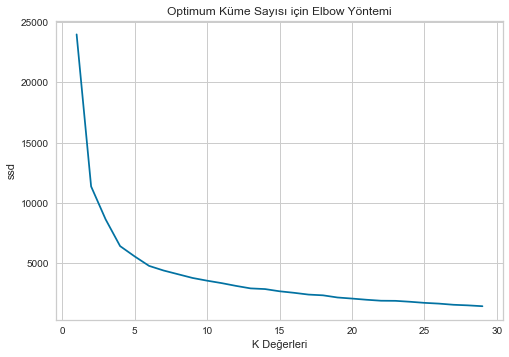

In [174]:
plt.plot(K, ssd, "bx-")
plt.xlabel("K Değerleri")
plt.ylabel("ssd")
plt.title("Optimum Küme Sayısı için Elbow Yöntemi")
plt.show()

Yukarıdaki grafiği incelediğimizde küme sayımız artış gösterdikçe hata değerinin düştüğünü gözlemleyebiliyoruz. Fakat buna göre bir değer belirleyecek olursak hatalı bir karar almış oluruz. Bunun sebebi zaten veri setindeki her bir gözlemin kendi başına bir küme olduğu zaman hata değerimiz 0 olacaktır, fakat gözlem sayısı kadar küme elde etmiş oluruz. Dolayısıyla burada en düşük hataya göre değil, ssd değerinin en çok değiştiği K değerini ideal küme sayımız olarak belileyeceğiz. 

Buna göre inceleme yaptığımızda k değerimizin 6 olabileceği yorumunu yapıyoruz.

Bu işlemi bir de KElbowVisualizer yöntemi ile yapalım. Bu yöntemde bize yukarıdaki gibi grafik çıkarmakla kalmıyor, en ideal olabilecek k değerini otomatik olarak işaretliyor.

In [175]:
elbow = KElbowVisualizer(kmeans, k=(2, 20))

Bu yöntem bazen hata verebilmekte. Bu senaryoda *rfm_analysis* veri setindeki değişkenler kategorik olduğundan dolayı hata alınmakta. Dolayısıyla aşağıdaki fonksiyonu kullanarak *rfm_analysis* içerisindeki değişkenleri float tipine çeviriyoruz. Bu şekilde hatanın önüne geçebiliriz.

In [176]:
# valueerror hatasından kurtulmak için aşağıdaki fonksiyonu buldum, veri tiplerini float yapıyor işe yaradı.
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [177]:
rfm_deneme = clean_dataset(rfm_analysis)

In [178]:
rfm_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3969 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Recency_score    3969 non-null   category
 1   Frequency_score  3969 non-null   category
 2   Monetary_score   3969 non-null   category
dtypes: category(3)
memory usage: 43.3 KB


In [179]:
rfm_deneme.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3969 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Recency_score    3969 non-null   float64
 1   Frequency_score  3969 non-null   float64
 2   Monetary_score   3969 non-null   float64
dtypes: float64(3)
memory usage: 124.0 KB


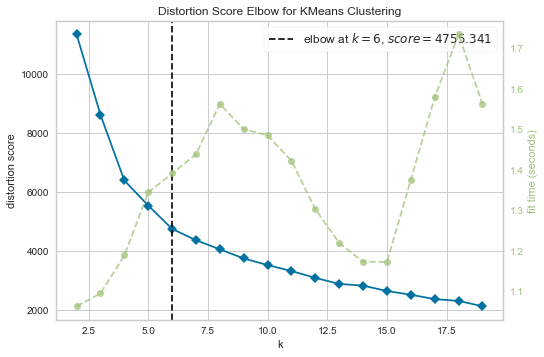

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [180]:
elbow.fit(rfm_deneme)
elbow.show()

Burada da görüldüğü üzere k değerimizin 6 olduğu durum bizim için en ideal küme sayısı olacaktır. Bu değeri görsel olarak değil de bir kod ile yakalayabilmek için aşağıdaki yöntemi kullanabiliriz. Bu bize yukarıdaki grafikte seçilen değeri döndürecek.

In [181]:
elbow.elbow_value_

6

# Final Model

In [182]:
rfm_analysis.head()

,Recency_score,Frequency_score,Monetary_score
Customer ID,,,
12346.0,2,3,2
12608.0,3,2,2
12745.0,2,2,3
12746.0,2,2,2
12747.0,5,5,5


In [183]:
# yukarıdaki yöntemde bulduğumuz ideal küme sayısını elbow.elbow_value_ kodu ile giriyoruz
kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(rfm_analysis)

Kümeleme işlemini tamamladık. Her bir müşterilerin bulunduğu segment değerini gözlemleyebiliriz.

In [184]:
kmeans.labels_

array([0, 2, 0, ..., 3, 4, 1])

Bu değerleri bir değişken olarak veri setimize ekleyebiliriz.

In [185]:
clusters = kmeans.labels_

In [186]:
rfm_analysis["Segments"] = clusters

In [187]:
rfm_analysis.head()

,Recency_score,Frequency_score,Monetary_score,Segments
Customer ID,,,,
12346.0,2,3,2,0
12608.0,3,2,2,2
12745.0,2,2,3,0
12746.0,2,2,2,3
12747.0,5,5,5,1


Her bir segmentte kaç tane müşteri bulunuyor:

In [188]:
rfm_analysis["Segments"].value_counts()

1    908
3    857
5    669
2    552
0    508
4    475
Name: Segments, dtype: int64

Şimdi recency, frequency ve monetary değerlerinin skorlanmadan önceki değerlerini bir final df içerisine alıp yanına da segmentleri ekleyerek segmentlere göre analizler yapabiliriz.

In [189]:
final_df = rfm[["recency", "frequency", "monetary"]]

In [190]:
final_df["segments"] = rfm_analysis["Segments"]

In [191]:
final_df.head()

,recency,frequency,monetary,segments
Customer ID,,,,
12346.0,165,33.0,372.0,0
12608.0,40,16.0,415.0,2
12745.0,122,22.0,723.0,0
12746.0,176,17.0,254.0,3
12747.0,5,154.0,5080.0,1


In [192]:
final_df.groupby("segments").agg({"recency": ["mean", "median", "count"],
                                 "frequency": ["mean", "median", "count"],
                                 "monetary": ["mean", "median", "count"]})

recency                frequency                  monetary  \
                mean median count        mean median count         mean   
segments                                                                  
0         163.125984  140.5   508   43.057087   40.0   508   911.919291   
1          13.901982   12.0   908  211.095815  164.0   908  3399.839207   
2          35.005435   33.0   552   16.760870   15.0   552   283.146739   
3         214.642940  214.0   857   15.039673   13.0   857   231.758460   
4          88.886316   66.0   475  141.957895  108.0   475  2417.562105   
5          30.754858   28.0   669   50.792227   46.0   669   824.979073   

                        
          median count  
segments                
0          678.5   508  
1         2502.5   908  
2          251.5   552  
3          208.0   857  
4         1895.0   475  
5          696.0   669